## 安徽省安庆市2304模拟垂直剖面
## `AH_2304 Vertical Section`

---
*@author: Evan*\
*@date: 2023-05-09*

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from matplotlib import rcParams
config = {
    "font.family":'Times New Roman',
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
}
rcParams.update(config)

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.io.shapereader import Reader

# silence the warning note
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
sys.path.append('../src/')
from findpoint import findpoint

## 选择剖面位置

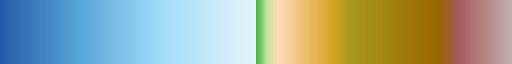

In [2]:
import cmaps
from matplotlib.colors import ListedColormap
import matplotlib as mpl

cmap1=cmaps.WhiteBlue_r
cmap2=cmaps.WhiteGreen_r
cmap3=cmaps.GMT_globe

list1=cmap1(np.linspace(0.2,0.85,1000))
list2=cmap2(np.linspace(0.5,0.8,40))
list3=cmap3(np.linspace(0.51,0.85,960))
ncolor=np.vstack((list1,list2,list3))
newmap=ListedColormap(ncolor)

newmap

In [3]:
DEMFile = 'F:/Data/Height_World/ETOPO2v2c_f4.nc'
DEMDs = xr.open_dataset(DEMFile)
dem = DEMDs['z'].values
dem_lat = DEMDs['y'].values
dem_lon = DEMDs['x'].values

dem_lons, dem_lats = np.meshgrid(dem_lon, dem_lat)

cmap = mpl.cm.terrain
vmin = -5000
vmax = 5000

In [4]:
shp_nanhai=Reader('F:/shapefile/南海诸岛/bou2_4l.shp') # 完整的国界省界九段线
shp_Sheng_new=Reader('F:/shapefile/区县级行政区划数据-审图号：GS（2022）1873号/调整/省.shp')
shp_Shi_new=Reader('F:/shapefile/区县级行政区划数据-审图号：GS（2022）1873号/调整/市.shp')

In [3]:
lon1, lat1 = 116.6, 31.1
lon2, lat2 = 117.5, 30.1

lon3, lat3 = 116.1, 29.7
lon4, lat4 = 117.4, 30.9

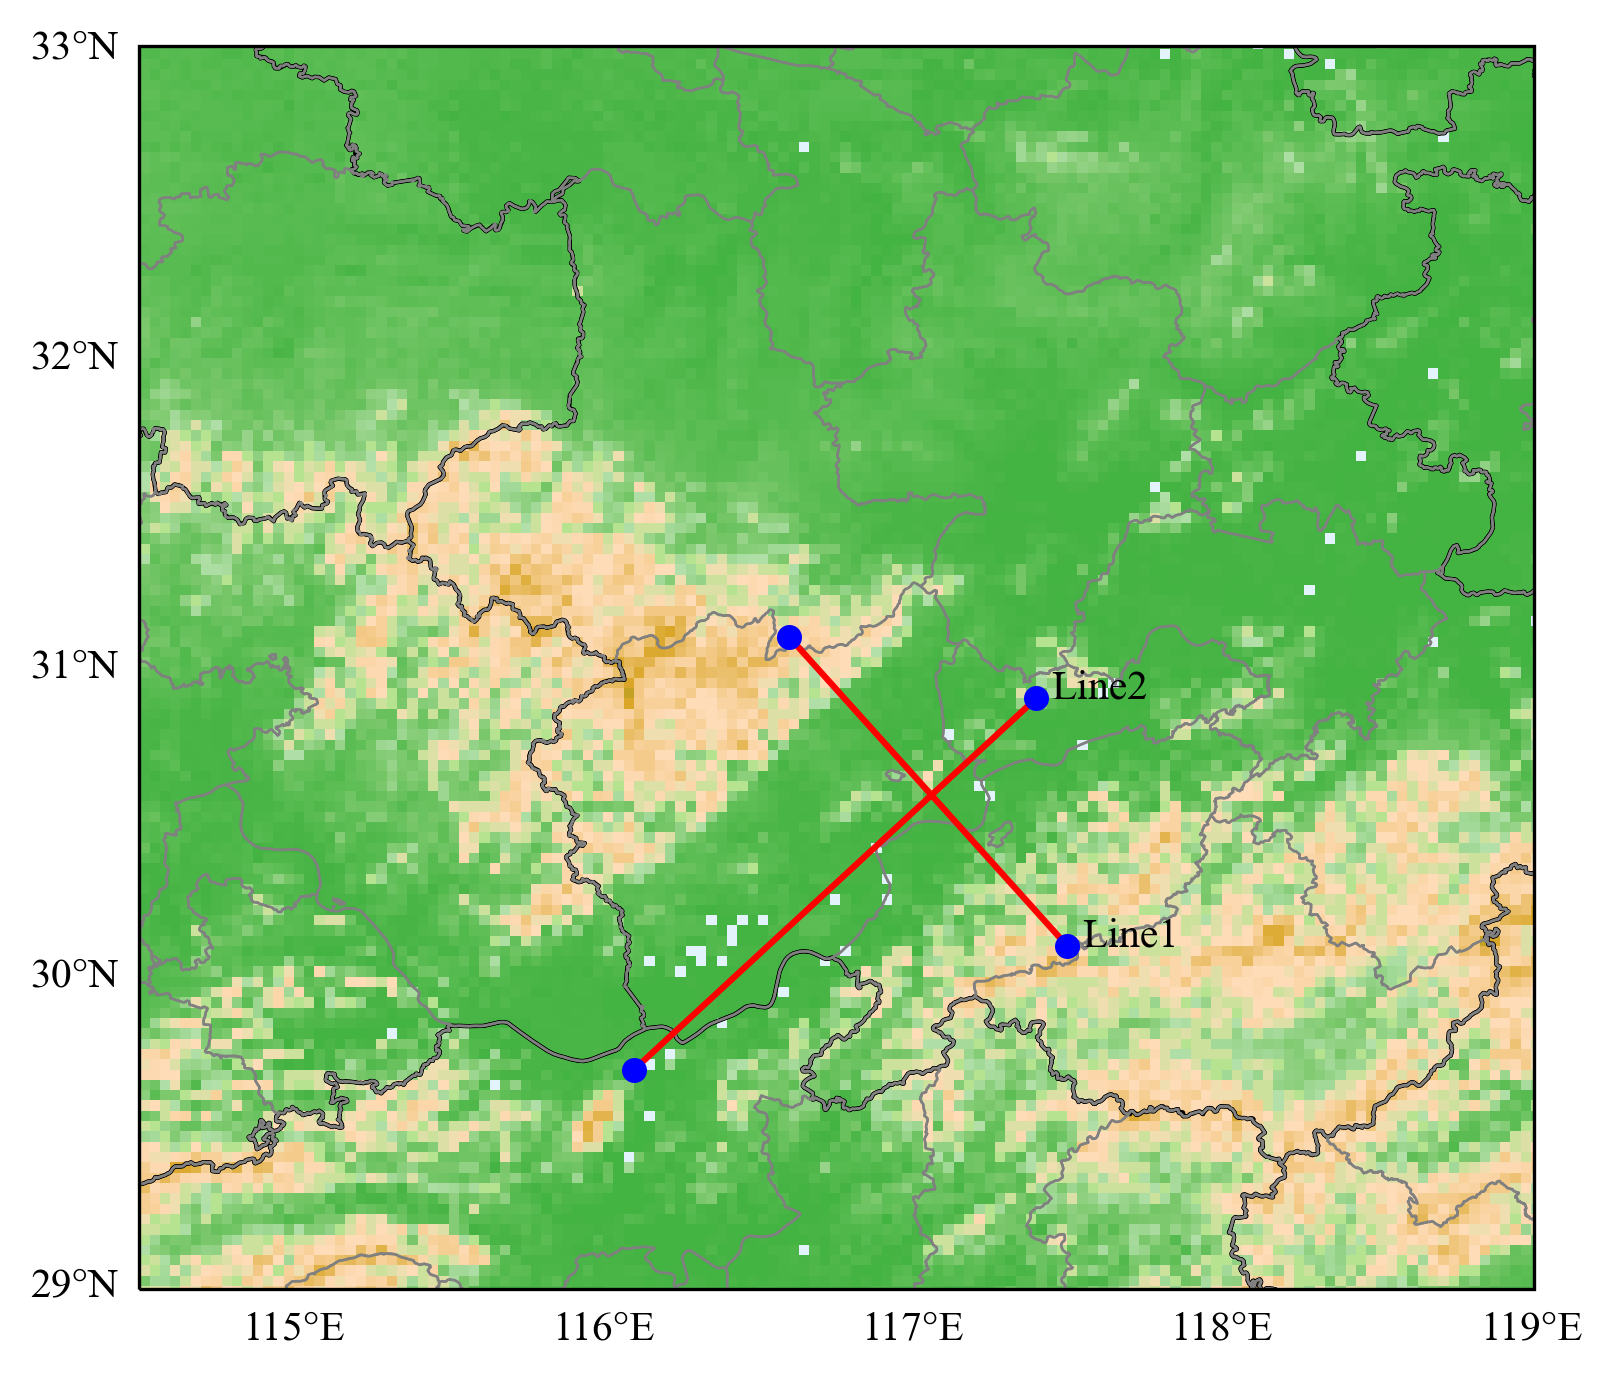

In [25]:
proj=ccrs.PlateCarree()

fig = plt.figure(figsize=(6,6),dpi=300)
ax = fig.subplots(1,1,subplot_kw={'projection':proj})
# ax.add_feature(cfeat.ShapelyFeature(shp_nanhai.geometries(),ccrs.PlateCarree(),edgecolor='gray',facecolor='None'), linewidth=0.6)
ax.add_feature(cfeat.ShapelyFeature(shp_Sheng_new.geometries(),ccrs.PlateCarree(),edgecolor='k',facecolor='None'), linewidth=1)
ax.add_feature(cfeat.ShapelyFeature(shp_Shi_new.geometries(),ccrs.PlateCarree(),edgecolor='gray',facecolor='None'), linewidth=0.6)
gl=ax.gridlines(
        xlocs=np.arange(-180, 180 + 1, 1), ylocs=np.arange(-90, 90 + 1, 1),
        draw_labels=True, x_inline=False, y_inline=False,
        linewidth=0, linestyle='--', color='gray')
gl.top_labels = False
gl.right_labels =False
gl.rotate_labels=False

ax.set_extent([114.5, 119.01, 28.99, 33.01])

cp=ax.pcolormesh(dem_lons, dem_lats, dem, cmap=newmap, vmin=vmin, vmax=vmax, alpha=1, transform=ccrs.PlateCarree(), zorder=0)

# fig.subplots_adjust(right=0.9,wspace=0.12)
# position= fig.add_axes([0.92,0.15,0.015,0.66])
# cbar=fig.colorbar(cp,cax=position,extend='both')
# cbar.set_ticks(np.arange(-5000,5001,1000))
# cbar.set_ticklabels(np.arange(-5,5.1,1))
# cbar.ax.set_title('km')

ax.plot([lon1, lon2], [lat1, lat2], 'r', transform=proj)
ax.plot(lon1, lat1, 'bo', markersize=5, transform=proj)
ax.plot(lon2, lat2, 'bo', markersize=5, transform=proj)
ax.text(lon2+0.05,lat2,'Line1',transform=proj)

ax.plot([lon3, lon4], [lat3, lat4], 'r', transform=proj)
ax.plot(lon3, lat3, 'bo', markersize=5, transform=proj)
ax.plot(lon4, lat4, 'bo', markersize=5, transform=proj)
ax.text(lon4+0.05,lat4,'Line2',transform=proj)

plt.show()

## 读取数据

In [4]:
chemFile = xr.open_dataset('F:/Data/case_anqing/April/April_chem.nc')
metFile = xr.open_dataset('F:/Data/case_anqing/April/April_met.nc')

lat = chemFile.latitude
lon = chemFile.longitude

nlevel = 21
number = 50
NO2 = chemFile.NO2[:,:nlevel,:,:]

uwind = metFile.uwind[:,:nlevel,:,:]
vwind = metFile.vwind[:,:nlevel,:,:]
wwind = chemFile.wwind[:,:nlevel,:,:]

ht = chemFile.HT[:,:nlevel,:,:]
PBLH = metFile.PBLH[:,0,:,:]

print('lat & lon = ',lat.shape)
print('chem      = ',NO2.shape)

lat & lon =  (138, 135)
chem      =  (720, 21, 138, 135)


In [5]:
# 根据需要计算日平均或MDA8
avg = NO2.resample({'time':'D'}).mean()

ht = ht.resample({'time':'D'}).mean(dim='time')
uu = uwind.resample({'time':'D'}).mean(dim='time')
vv = vwind.resample({'time':'D'}).mean(dim='time')
ww = wwind.resample({'time':'D'}).mean(dim='time')
PBLH = PBLH.resample({'time':'D'}).max(dim='time')

In [6]:
def get_section(lon1,lat1,lon2,lat2,number,var,ht,uu,vv,ww,PBLH):
    
    # 生成沿两个点连线的坐标
    lons = np.linspace(lon1,lon2,num=number)
    lats = np.linspace(lat1,lat2,num=number)

    # 选取这些点在数据集中的最接近的网格点的数据
    x_index=[]
    y_index=[]

    for i in range(number):
        out_x, out_y = findpoint(lons[i],lats[i],var)
        x_index.append(out_x)
        y_index.append(out_y)
    datasel = var.isel(x=x_index, y=y_index)
    htsel = ht.isel(x=x_index, y=y_index)
    uusel = uu.isel(x=x_index, y=y_index)
    vvsel = vv.isel(x=x_index, y=y_index)
    wwsel = ww.isel(x=x_index, y=y_index)
    phsel = PBLH.isel(x=x_index, y=y_index)

    diag = np.diagonal(datasel, axis1=2, axis2=3)
    diag_ht = np.diagonal(htsel, axis1=2, axis2=3)
    diag_uu = np.diagonal(uusel, axis1=2, axis2=3)
    diag_vv = np.diagonal(vvsel, axis1=2, axis2=3)
    diag_ww = np.diagonal(wwsel, axis1=2, axis2=3)
    diag_ph = np.diagonal(phsel, axis1=1, axis2=2)

    # 计算选定方向的单位向量
    dx = lon2 - lon1
    dy = lat2 - lat1
    norm = np.sqrt(dx**2+dy**2)
    direction = np.array([dx/norm,dy/norm])

    # 计算合成风矢量与选定方向单位向量的点积，即为所求投影的长度（含正负）
    cos_theta = np.zeros_like(diag_uu)
    for m in range(30):
        for n in range(nlevel):
            for i in range(number):
                ws2 = np.array([diag_uu[m,n,i],diag_vv[m,n,i]])
                cos_theta[m,n,i]=np.dot(ws2, direction)

    p = cos_theta
    
    return diag, diag_ht, diag_ww, diag_ph, p

In [25]:
dates1 = np.arange(0,9).reshape(3,3)
dates2 = np.arange(9,18).reshape(3,3)
dates3 = np.arange(18,27).reshape(3,3)

In [7]:
dates = np.arange(0,30).reshape(5,6)
dates

array([[ 0,  1,  2,  3,  4,  5],
       [ 6,  7,  8,  9, 10, 11],
       [12, 13, 14, 15, 16, 17],
       [18, 19, 20, 21, 22, 23],
       [24, 25, 26, 27, 28, 29]])

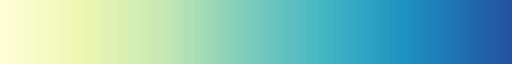

In [38]:
import cmaps

colormap = cmaps.MPL_YlGnBu[:100]
colormap

In [10]:
def plot_sections(dates, number, nlevel, xlabels, diag, diag_ht, diag_ww, diag_ph, p):

    xx = np.arange(0,number)
    xgrid = np.tile(xx,(nlevel,1))
    ygrid = diag_ht[0,:,:]

    cmax=61
    cmaplevel=np.arange(0,cmax,3)
    
    im = np.size(dates,0)
    jm = np.size(dates,1)
    
    fig = plt.figure(figsize=(20,16),dpi=300)
    ax = fig.subplots(im,jm,sharex=True,sharey=True)

    # ---------------ax:lon=113.3----------------
    for i in range(im):
        for j in range(jm):

            # contour map
            cp=ax[i][j].contourf(xgrid.T,ygrid.T,diag[dates[i][j],:,:].T,
                                    cmap='Spectral_r',levels=cmaplevel,extend='both')

            # fillbetween
            ax[i][j].fill_between(xgrid.T[:,0],0,ygrid.T[:,0],where=ygrid.T[:,0]>0,facecolor='k')

            # set label and ticks
            ax[i][j].set_xticks([0,10,20,30,40,49])
            ax[i][j].set_xticklabels(xlabels,fontsize=6)
            ax[i][j].set_yticks(np.arange(0,2001,500))
            ax[i][j].set_xlim(0,number-1)
            ax[i][j].set_ylim(0,2001)

            # wind quiver
            interval=3
            q=ax[i][j].quiver(xgrid[0:nlevel:interval,0:number:interval],
                            ygrid[0:nlevel:interval,0:number:interval],
                            p[dates[i][j],0:nlevel:interval,0:number:interval],
                            diag_ww[dates[i][j],0:nlevel:interval,0:number:interval]*50,
                    color='k',alpha=1,scale=200,headwidth=3)
                
            # PBL height
            ax[i][j].plot(xgrid.T[:,0],diag_ph[dates[i][j],:],linewidth=1,linestyle='--',color='tab:blue')
        
            # add triangles 
            # ax[i][j].text(23.14-0.02,-160,'▲',color='b')
        
            # set titles
            ax[i][j].set_title(pd.to_datetime('2023-04-'+str(dates[i][j]+1)).strftime('%Y-%m-%d'),size=12)

            if (i==4)&(j==3):
                ax[i][j].set_xlabel('Coordinate')
            if (i==2)&(j==0):
                ax[i][j].set_ylabel('Height(m)')

    # quiverkey
    ax[2][2].quiverkey(q,X=1.14,Y=0.01,U=10,angle=0,label='5m/s',labelpos='E')
    ax[2][2].quiverkey(q,X=1.09,Y=0.044,U=10,angle=90,label='10cm/s',labelpos='N')

    # share colorbar
    fig.subplots_adjust(right=0.9)
    position= fig.add_axes([0.92,0.15,0.015,0.7])
    cbar=fig.colorbar(cp,cax=position)
    cbar.set_ticks(np.arange(0,cmax+1,20))
    cbar.set_label('$\mu$$g$/$m^3$')

    fig.subplots_adjust(wspace=0.1,hspace=0.2)
    # plt.suptitle('',size=14)

    plt.show()

## 绘制剖面填色图

### Line 1

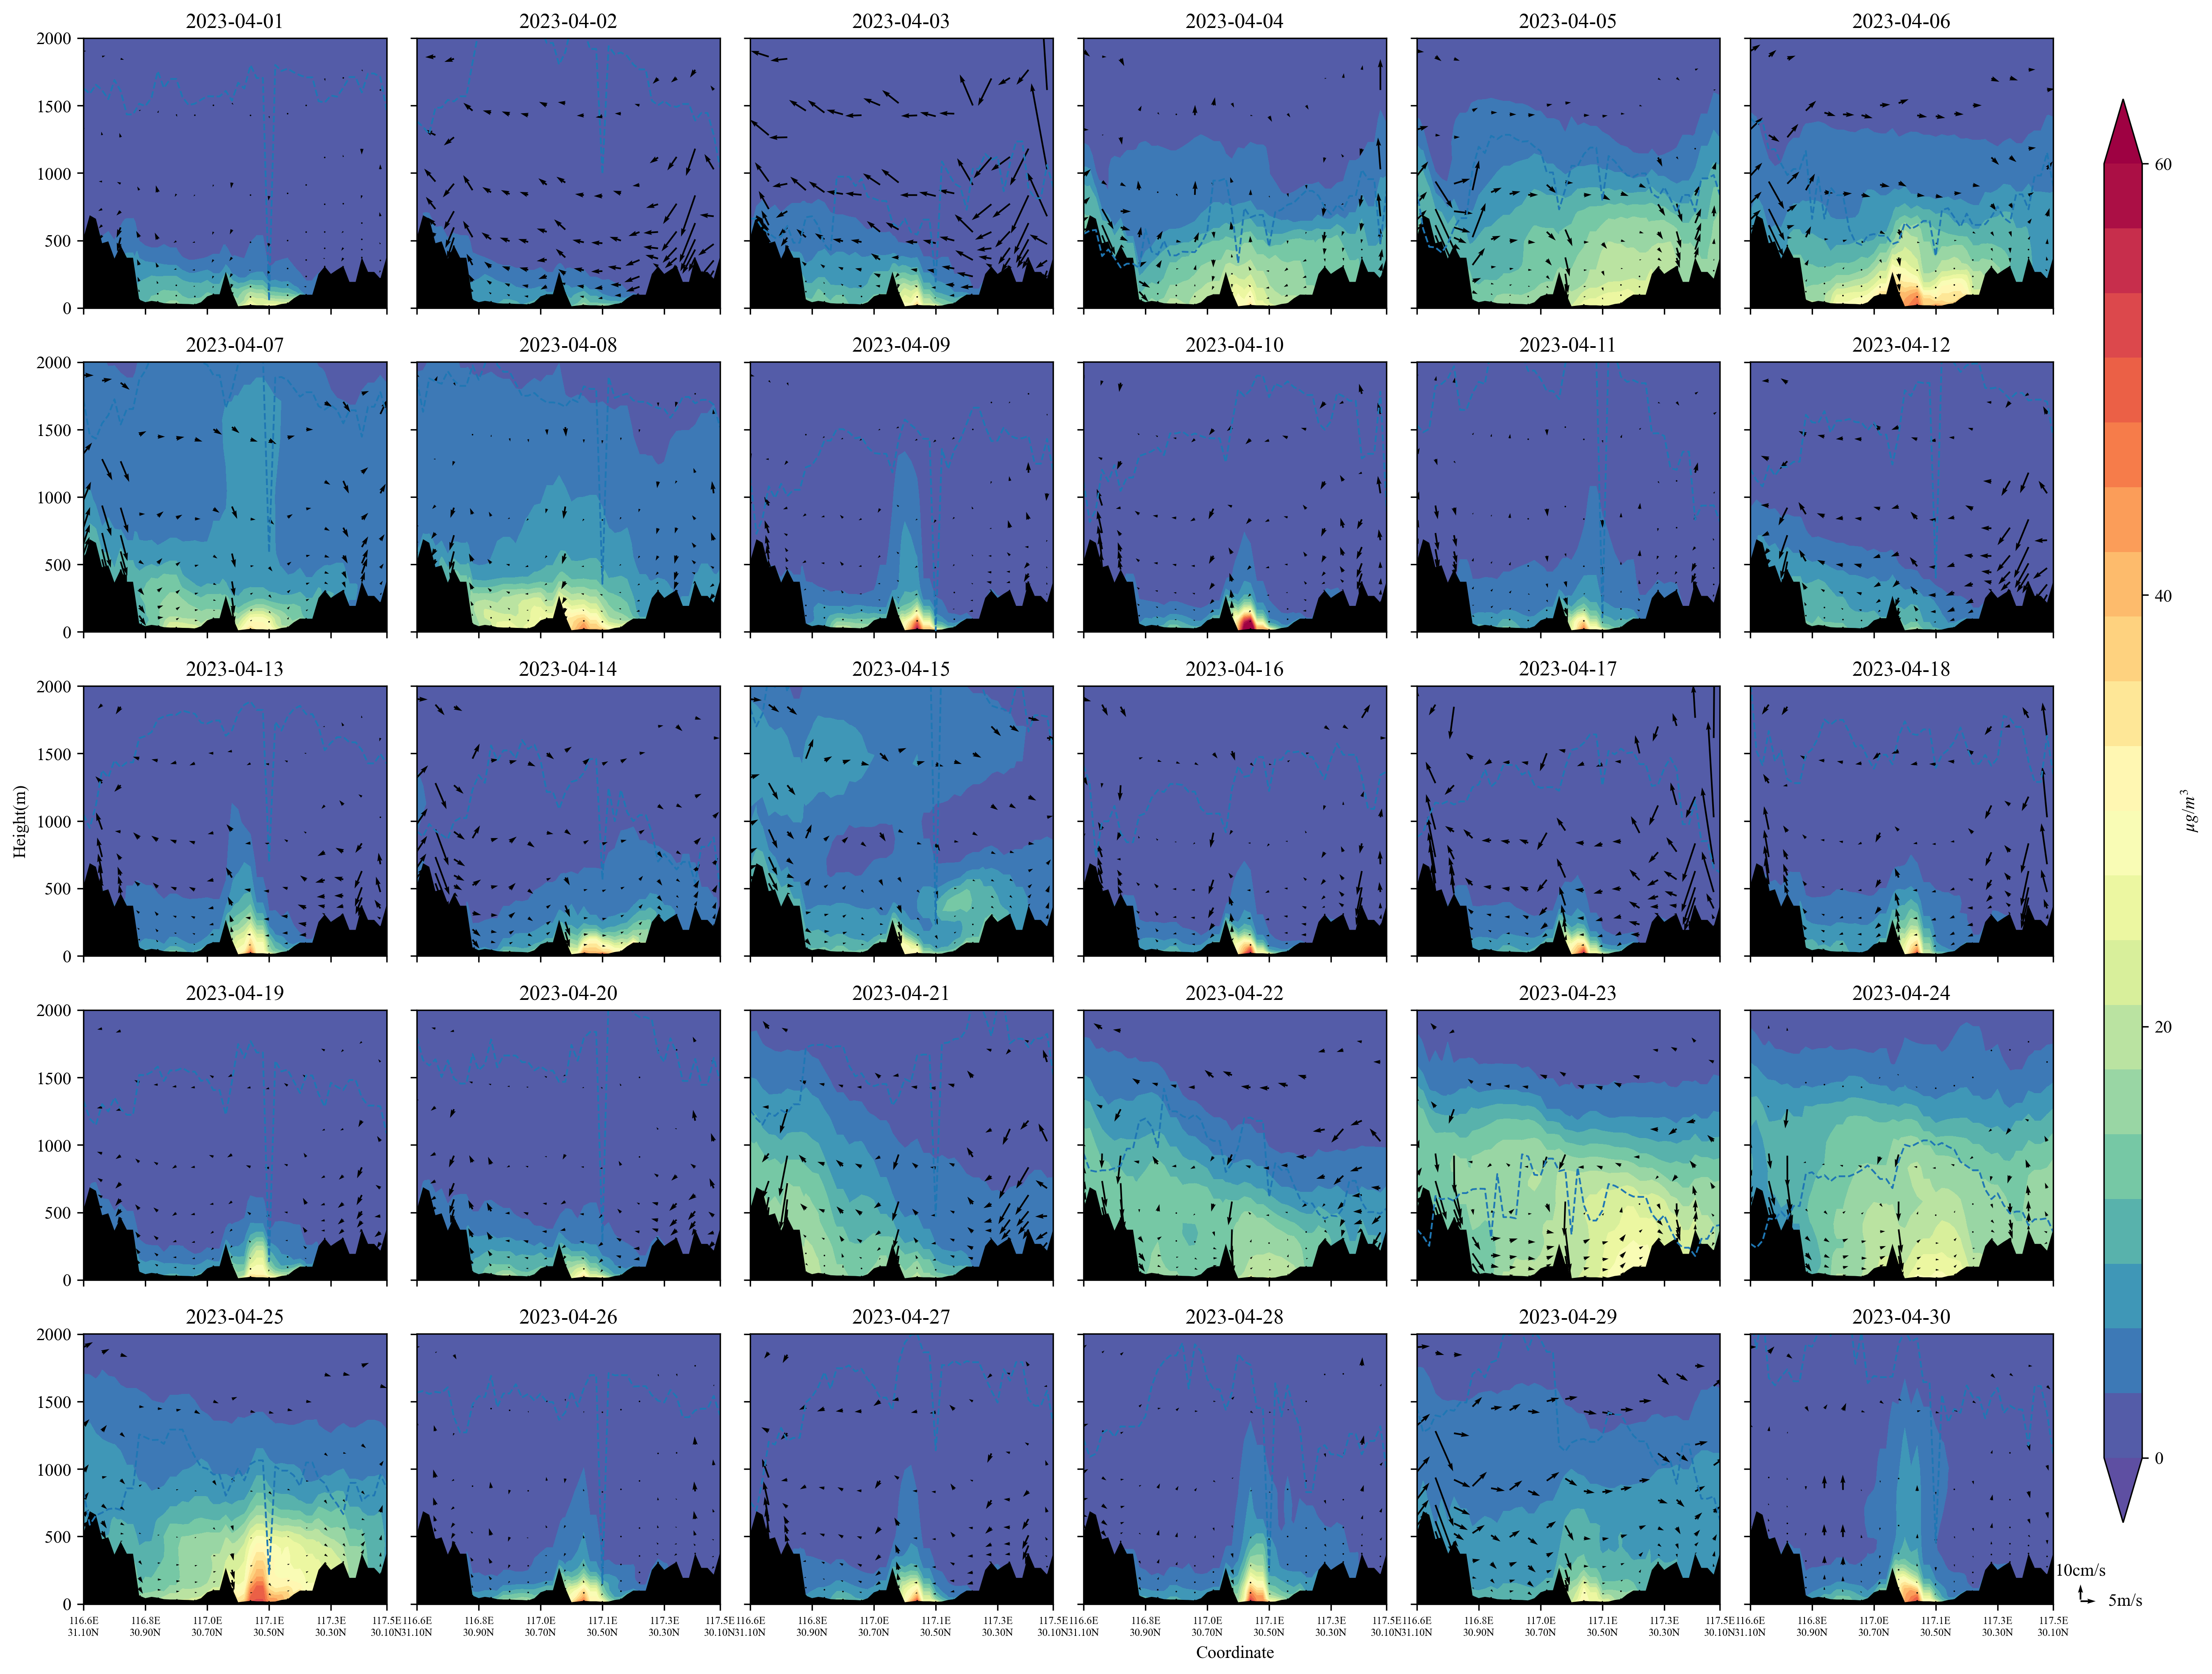

In [11]:
diag, diag_ht, diag_ww, diag_ph, p = get_section(lon1,lat1,lon2,lat2,number,
                                                 avg,ht,uu,vv,ww,PBLH)
xlabels = []
for i in range(6):
    x = lon1 + (lon2 - lon1) / 5 * i
    y = lat1 + (lat2 - lat1) / 5 * i
    xlabels.append(f"{x:.1f}E\n{y:.2f}N")
plot_sections(dates, number, nlevel, xlabels, diag, diag_ht, diag_ww, diag_ph, p)

### Line 2

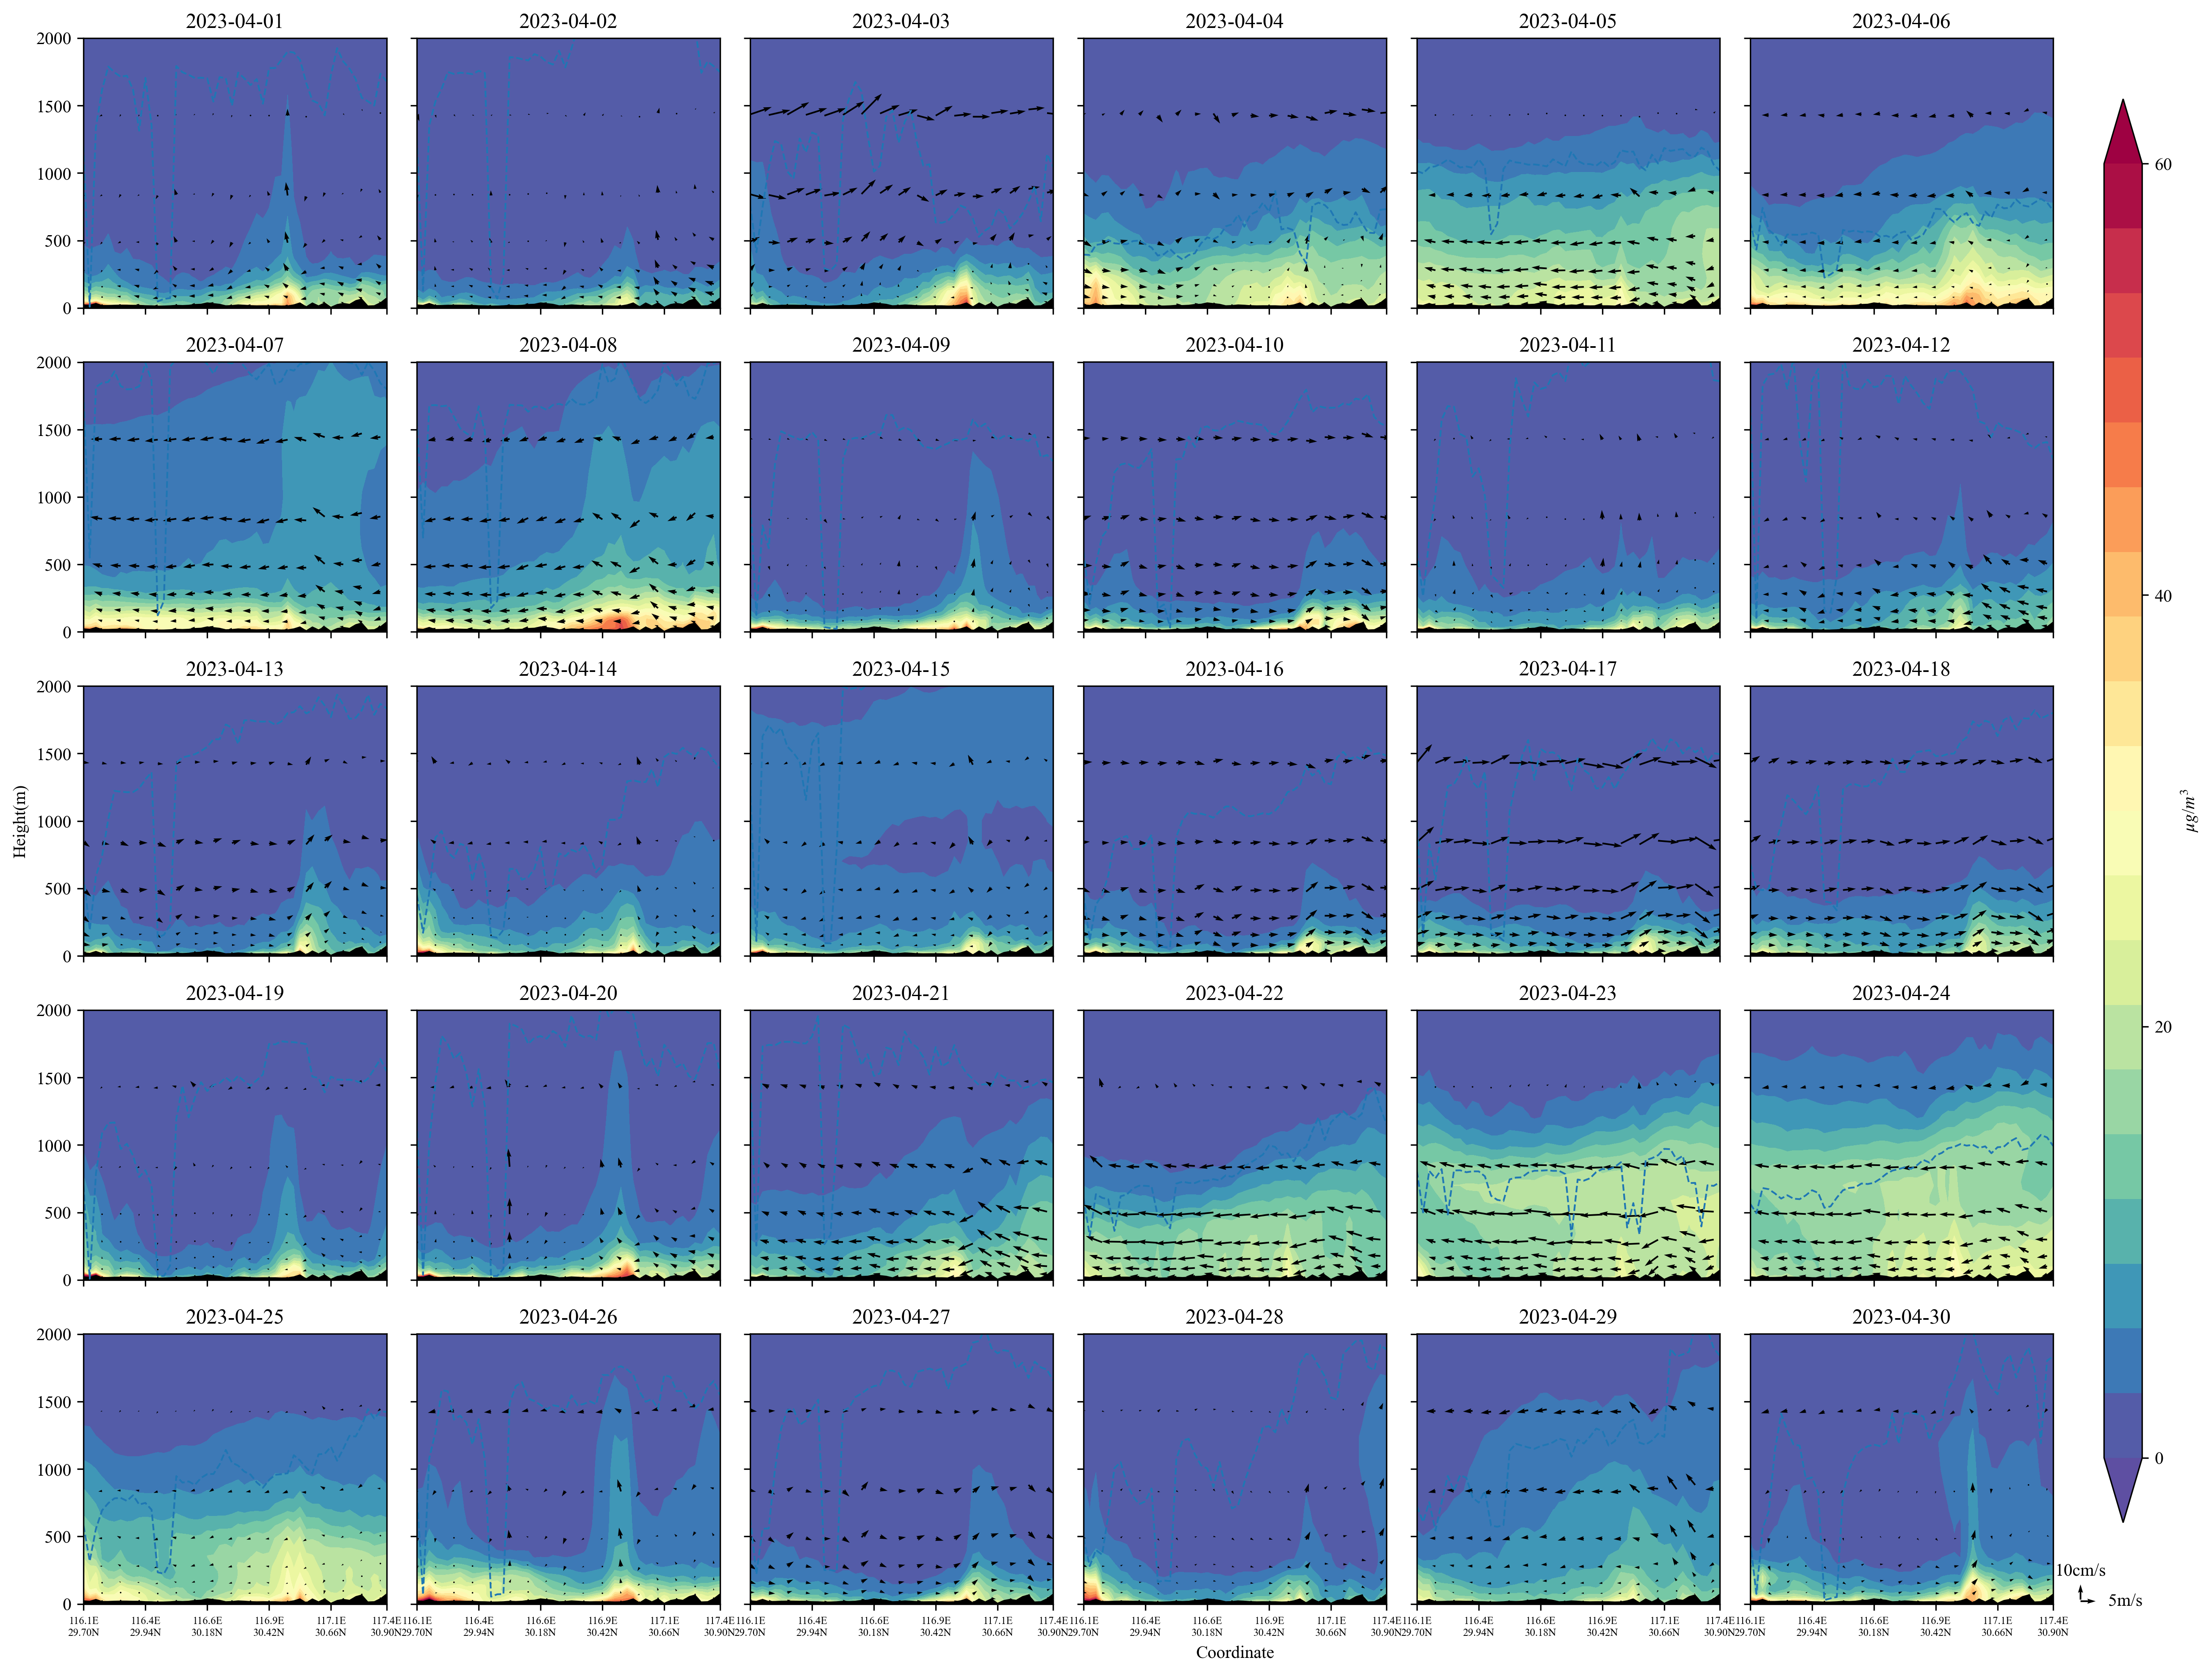

In [12]:
diag, diag_ht, diag_ww, diag_ph, p = get_section(lon3,lat3,lon4,lat4,number,
                                                 avg,ht,uu,vv,ww,PBLH)
xlabels = []
for i in range(6):
    x = lon3 + (lon4 - lon3) / 5 * i
    y = lat3 + (lat4 - lat3) / 5 * i
    xlabels.append(f"{x:.1f}E\n{y:.2f}N")
plot_sections(dates, number, nlevel, xlabels, diag, diag_ht, diag_ww, diag_ph, p)